<a href="https://colab.research.google.com/github/soumya527/News-Feedback-System/blob/main/visualization/Bert-result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 2.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
!pip install accelerate -U

In [ ]:
!pip install torch datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.9 MB/s eta 0:00:00


In [ ]:
!pip install transformers[torch] accelerate -U

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Create necessary directories
os.makedirs('./results', exist_ok=True)
os.makedirs('./logs', exist_ok=True)


In [ ]:
# Load the dataset
df = pd.read_csv('Random.csv')

# Prepare the data
X = df['Headline'].tolist()
y = df['Sentiment'].tolist()

# Encode the labels
label_map = {'Neutral': 0, 'Negative': 1, 'Positive': 2}
y = [label_map[label] for label in y]


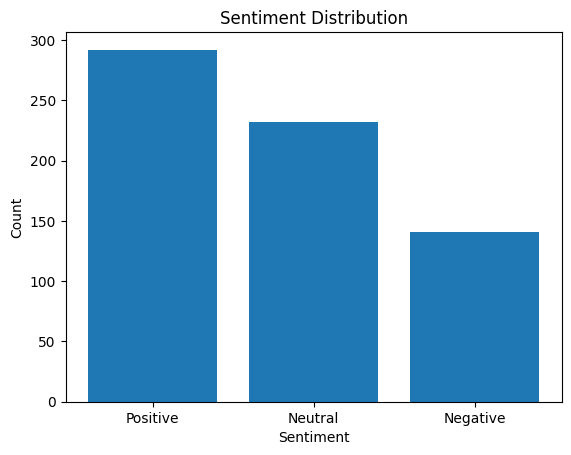

In [ ]:
# prompt: count the number of positive, neutral, negative sentiments in the file and plot it in a bar chart

import matplotlib.pyplot as plt

# Count the number of positive, neutral, and negative sentiments
positive_count = 0
neutral_count = 0
negative_count = 0
for sentiment in y:
  if sentiment == 0:
    neutral_count += 1
  elif sentiment == 1:
    negative_count += 1
  else:
    positive_count += 1

# Create a bar chart
labels = ['Positive', 'Neutral', 'Negative']
values = [positive_count, neutral_count, negative_count]
plt.bar(labels, values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()


In [ ]:
# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the input
encodings = tokenizer(X, truncation=True, padding=True, max_length=128)

# Convert to torch tensors
input_ids = torch.tensor(encodings['input_ids'])
attention_masks = torch.tensor(encodings['attention_mask'])
labels = torch.tensor(y)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Create dataset class
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

# Split the data into training and testing sets
dataset = SentimentDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


In [ ]:
df.head()

,Ministry,Headline,Sentiment
0,Ministry of Home Affairs (MHA),"Citizens and the State: Policing, Impunity, an...",Negative
1,Ministry of Home Affairs (MHA),"To simplify colonial laws, MHA asks state DGPs...",Positive
2,Ministry of Home Affairs (MHA),Democracy in India - Chatham House,Neutral
3,Ministry of Home Affairs (MHA),UPSC tightens guidelines for appointment of St...,Positive
4,Ministry of Home Affairs (MHA),Press Information Bureau - PIB,Neutral


In [ ]:
# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Define training arguments with regularization techniques
training_args = TrainingArguments(
    output_dir='./results',  # Directory for model output
    num_train_epochs=3,  # Number of training epochs
    per_device_train_batch_size=8,  # Batch size for training
    per_device_eval_batch_size=8,  # Batch size for evaluation
    evaluation_strategy='epoch',  # Evaluate every epoch
    save_strategy='epoch',  # Save model every epoch
    logging_dir='./logs',  # Directory for logs
    logging_steps=100,  # Log every 100 steps
    # Regularization techniques
    weight_decay=0.01,  # Weight decay for regularization
    # dropout=0.1,  # Dropout rate for regularization (uncomment to use dropout)
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
trainer.train()


Epoch,Training Loss,Validation Loss
1,No log,0.643692
2,0.770700,0.666148
3,0.280500,0.820267


TrainOutput(global_step=201, training_loss=0.5233011356003545, metrics={'train_runtime': 1315.1411, 'train_samples_per_second': 1.214, 'train_steps_per_second': 0.153, 'total_flos': 54131474550384.0, 'train_loss': 0.5233011356003545, 'epoch': 3.0})

In [ ]:
# Define the directory to save the trained model
model_directory = './saved_model'

# Create the directory if it doesn't exist
os.makedirs(model_directory, exist_ok=True)

trainer.save_model(model_directory)


In [ ]:
# Evaluate the model
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)

# Convert predictions to sentiment labels
inv_label_map = {0: 'Neutral', 1: 'Negative', 2: 'Positive'}
y_pred = [inv_label_map[pred] for pred in preds]



# Handle unknown labels gracefully
y_test = []
for label_tensor in test_dataset.dataset.labels[test_dataset.indices]:
    label = label_tensor.item()  # Convert tensor to integer
    print("Label:", label)
    if label in inv_label_map:
        y_test.append(inv_label_map[label])
    else:
        y_test.append('Unknown')

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


Label: 1
Label: 0
Label: 2
Label: 0
Label: 2
Label: 2
Label: 2
Label: 2
Label: 1
Label: 0
Label: 0
Label: 1
Label: 2
Label: 0
Label: 1
Label: 0
Label: 0
Label: 1
Label: 2
Label: 2
Label: 0
Label: 0
Label: 0
Label: 0
Label: 0
Label: 2
Label: 1
Label: 1
Label: 2
Label: 1
Label: 2
Label: 2
Label: 1
Label: 2
Label: 1
Label: 0
Label: 1
Label: 2
Label: 1
Label: 2
Label: 2
Label: 0
Label: 2
Label: 0
Label: 2
Label: 1
Label: 2
Label: 2
Label: 0
Label: 2
Label: 2
Label: 2
Label: 1
Label: 1
Label: 0
Label: 0
Label: 1
Label: 0
Label: 2
Label: 0
Label: 1
Label: 1
Label: 1
Label: 0
Label: 0
Label: 2
Label: 1
Label: 2
Label: 0
Label: 2
Label: 1
Label: 1
Label: 2
Label: 0
Label: 0
Label: 1
Label: 1
Label: 0
Label: 2
Label: 2
Label: 2
Label: 2
Label: 2
Label: 2
Label: 2
Label: 2
Label: 1
Label: 0
Label: 1
Label: 2
Label: 2
Label: 0
Label: 0
Label: 2
Label: 2
Label: 0
Label: 2
Label: 2
Label: 2
Label: 0
Label: 2
Label: 0
Label: 2
Label: 0
Label: 2
Label: 1
Label: 2
Label: 1
Label: 0
Label: 2
Label: 0
L

In [ ]:
# Print true labels and predicted labels
print("True Labels:", y_test)
print("Predicted Labels:", y_pred)


True Labels: ['Negative', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Positive', 'Positive', 'Positive', 'Negative', 'Neutral', 'Neutral', 'Negative', 'Positive', 'Neutral', 'Negative', 'Neutral', 'Neutral', 'Negative', 'Positive', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Negative', 'Negative', 'Positive', 'Negative', 'Positive', 'Positive', 'Negative', 'Positive', 'Negative', 'Neutral', 'Negative', 'Positive', 'Negative', 'Positive', 'Positive', 'Neutral', 'Positive', 'Neutral', 'Positive', 'Negative', 'Positive', 'Positive', 'Neutral', 'Positive', 'Positive', 'Positive', 'Negative', 'Negative', 'Neutral', 'Neutral', 'Negative', 'Neutral', 'Positive', 'Neutral', 'Negative', 'Negative', 'Negative', 'Neutral', 'Neutral', 'Positive', 'Negative', 'Positive', 'Neutral', 'Positive', 'Negative', 'Negative', 'Positive', 'Neutral', 'Neutral', 'Negative', 'Negative', 'Neutral', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Pos

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load the saved model
model_directory = './saved_model'
model = BertForSequenceClassification.from_pretrained(model_directory)

# Set the model to evaluation mode
model.eval()

# Define the function to predict sentiment for a headline
def predict_sentiment(headline):
    # Tokenize the input sentence
    inputs = tokenizer(headline, return_tensors='pt', truncation=True, padding=True)

    # Forward pass through the model
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted label
    predicted_label = torch.argmax(outputs.logits).item()

    # Map the numeric label to sentiment
    sentiment_mapping = {0: 'Neutral', 1: 'Negative', 2: 'Positive'}
    predicted_sentiment = sentiment_mapping[predicted_label]

    return predicted_sentiment

# Load the CSV file
csv_file = 'gres (1).csv'  # Replace 'your_csv_file.csv' with the path to your CSV file
df_new= pd.read_csv(csv_file)

# Define the column names
headline_column = 'Headline'
ministry_column = 'Ministry'

# Predict sentiments for each headline
predicted_sentiments = []
for headline in df_new[headline_column]:
    predicted_sentiments.append(predict_sentiment(headline))

# Add the predicted sentiments to the DataFrame
df_new['Sentiment'] = predicted_sentiments

# Save the DataFrame to a new CSV file with predictions
output_csv_file = 'predicted_data.csv'
df_new.to_csv(output_csv_file, index=False)

print(f"Predictions saved to '{output_csv_file}'")


Predictions saved to 'predicted_data.csv'


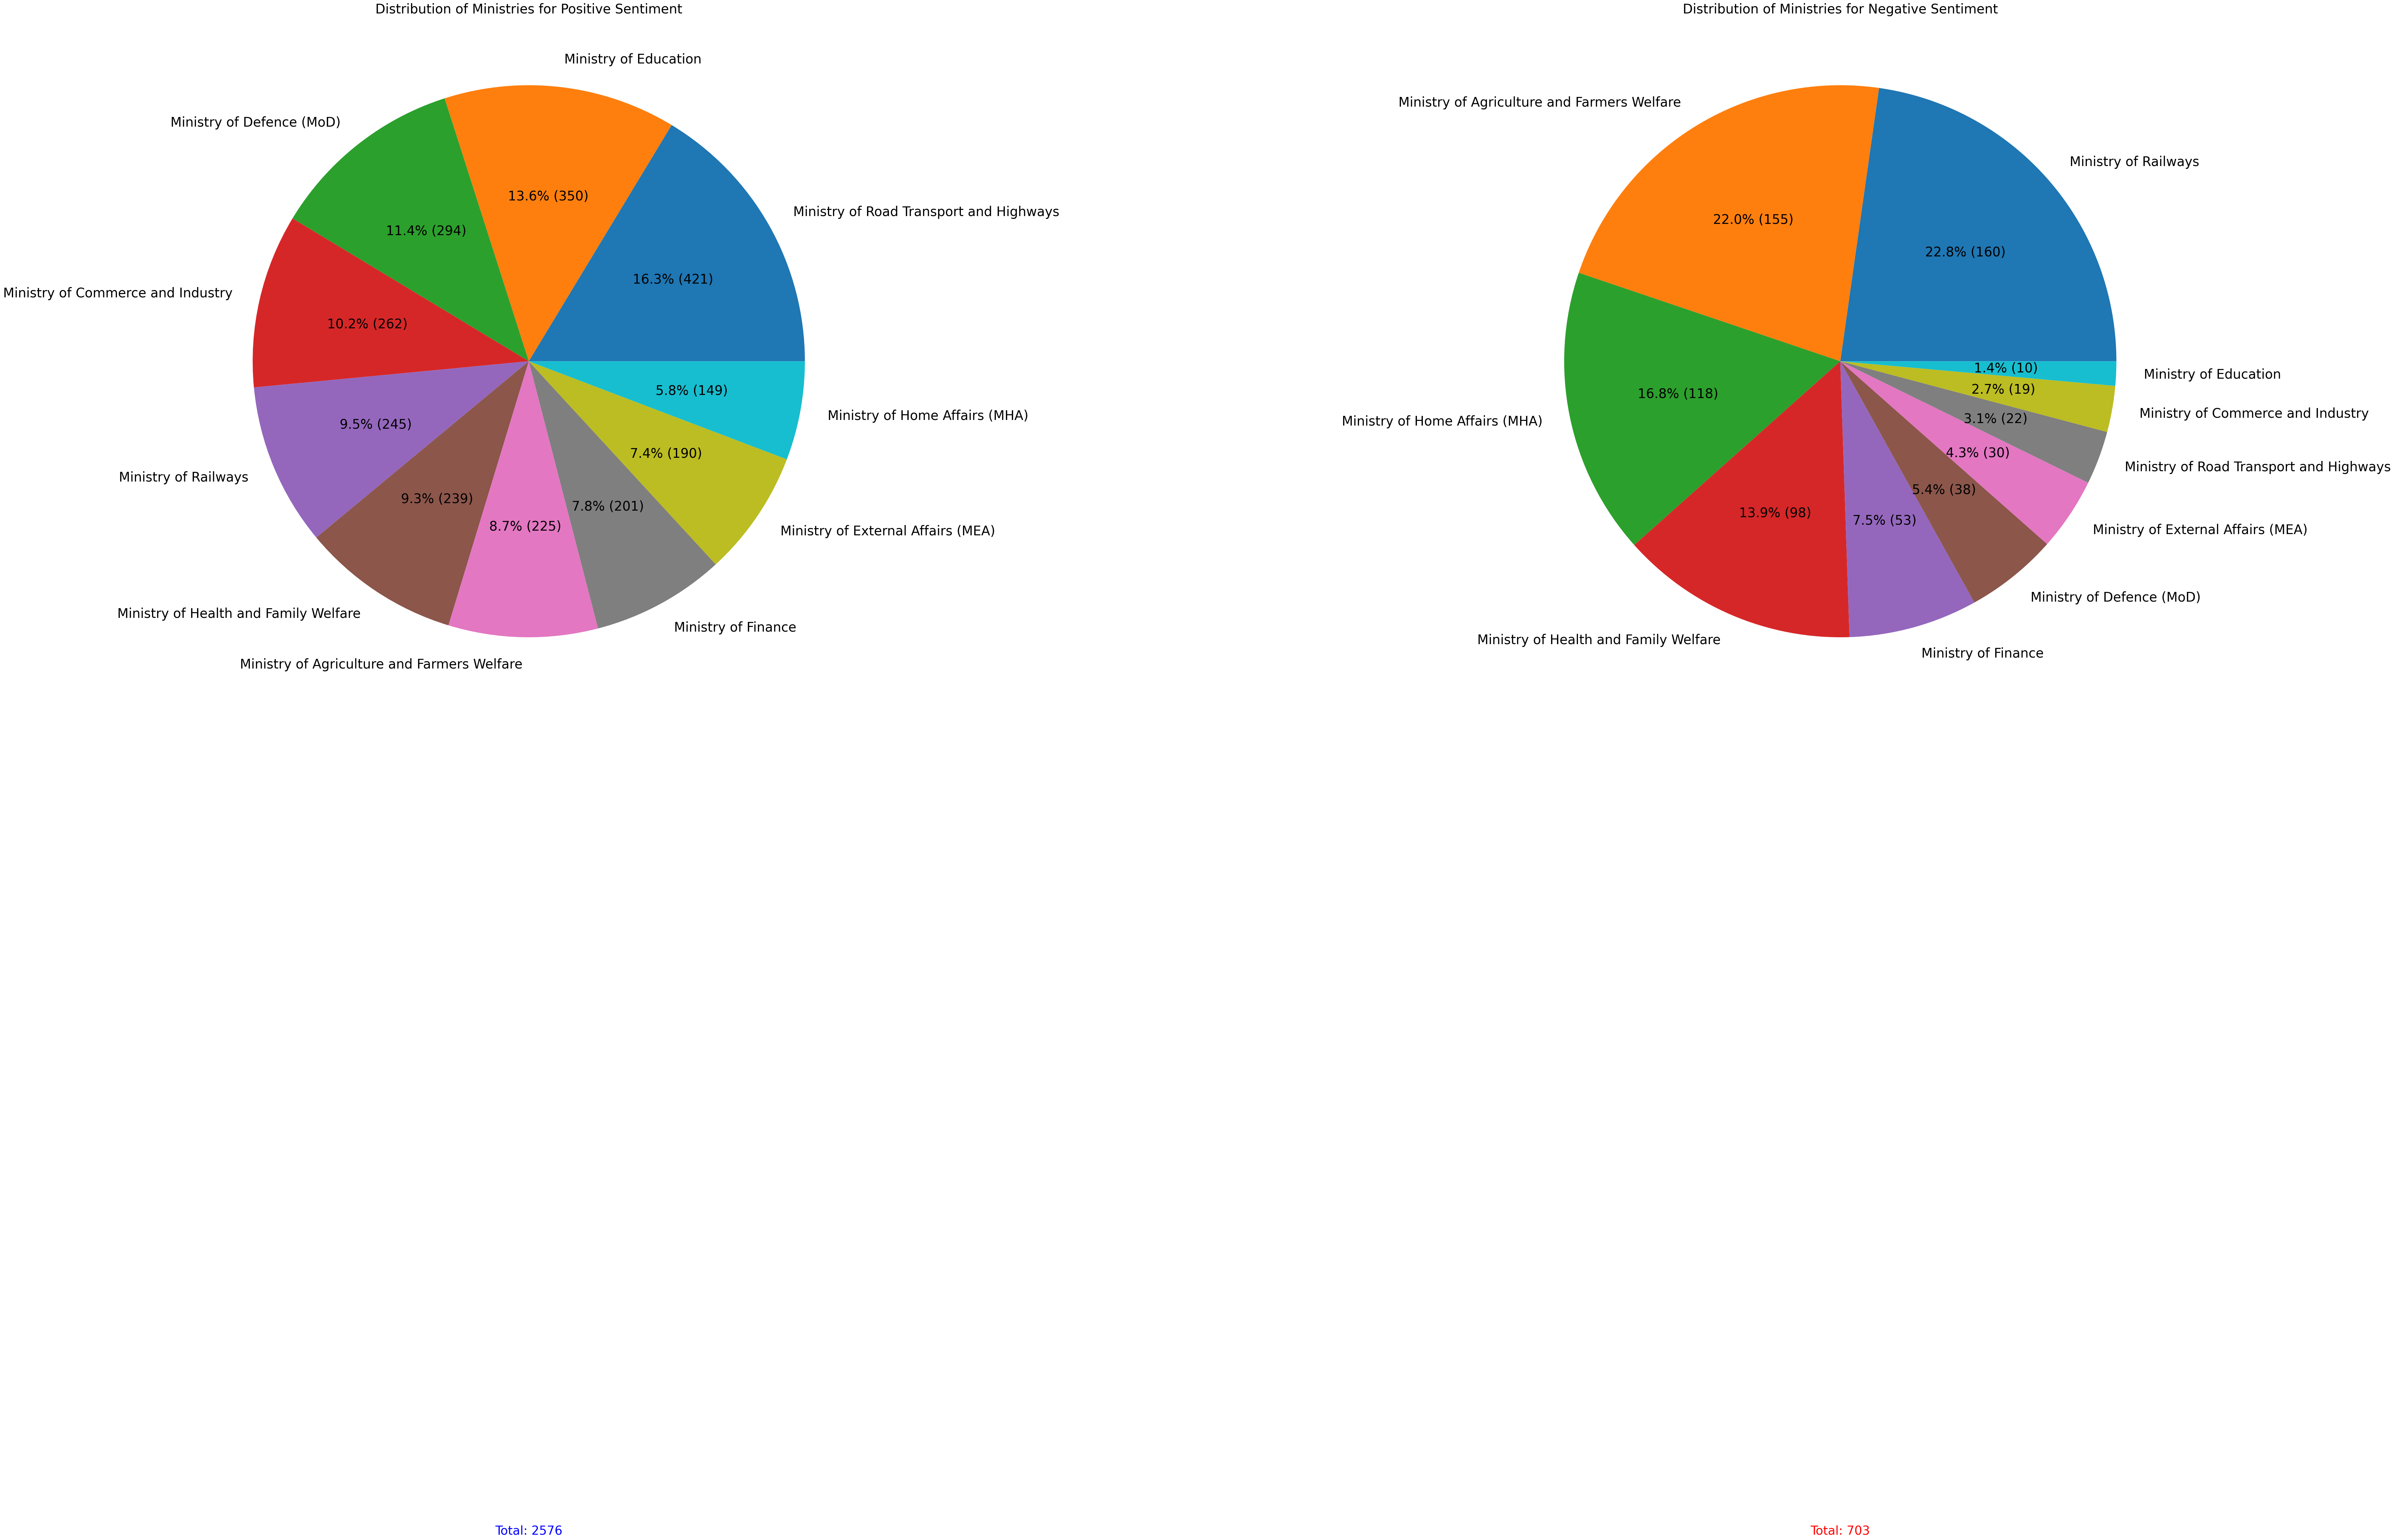

In [ ]:
import matplotlib.pyplot as plt

# Assuming df_new is your DataFrame and it has 'Sentiment' and 'Ministry' columns

# Filter data for positive sentiment
positive_df = df_new[df_new['Sentiment'] == 'Positive']

# Filter data for negative sentiment
negative_df = df_new[df_new['Sentiment'] == 'Negative']

# Count occurrences of each ministry for positive sentiment
positive_ministry_counts = positive_df['Ministry'].value_counts()

# Count occurrences of each ministry for negative sentiment
negative_ministry_counts = negative_df['Ministry'].value_counts()

# Define a function to format the labels with increased font size
def make_autopct(values, font_size=30):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return '{p:.1f}% ({v:d})'.format(p=pct, v=val)
    return my_autopct

# Plot pie chart for positive sentiment
fig, axes = plt.subplots(1, 2, figsize=(80, 40), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = axes[0].pie(positive_ministry_counts, labels=positive_ministry_counts.index, autopct=make_autopct(positive_ministry_counts))
for text in texts + autotexts:
    text.set_fontsize(30)
axes[0].set_title('Distribution of Ministries for Positive Sentiment', fontsize=30)

# Add total count annotation for positive sentiment
total_positive = positive_ministry_counts.sum()
axes[0].text(0.5, -1.2, f'Total: {total_positive}', ha='center', fontsize=28, color='blue', transform=axes[0].transAxes)

# Plot pie chart for negative sentiment
wedges, texts, autotexts = axes[1].pie(negative_ministry_counts, labels=negative_ministry_counts.index, autopct=make_autopct(negative_ministry_counts))
for text in texts + autotexts:
    text.set_fontsize(30)
axes[1].set_title('Distribution of Ministries for Negative Sentiment', fontsize=30)

# Add total count annotation for negative sentiment
total_negative = negative_ministry_counts.sum()
axes[1].text(0.5, -1.2, f'Total: {total_negative}', ha='center', fontsize=28, color='red', transform=axes[1].transAxes)

# Adjust spacing around the subplots
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.9)

plt.show()


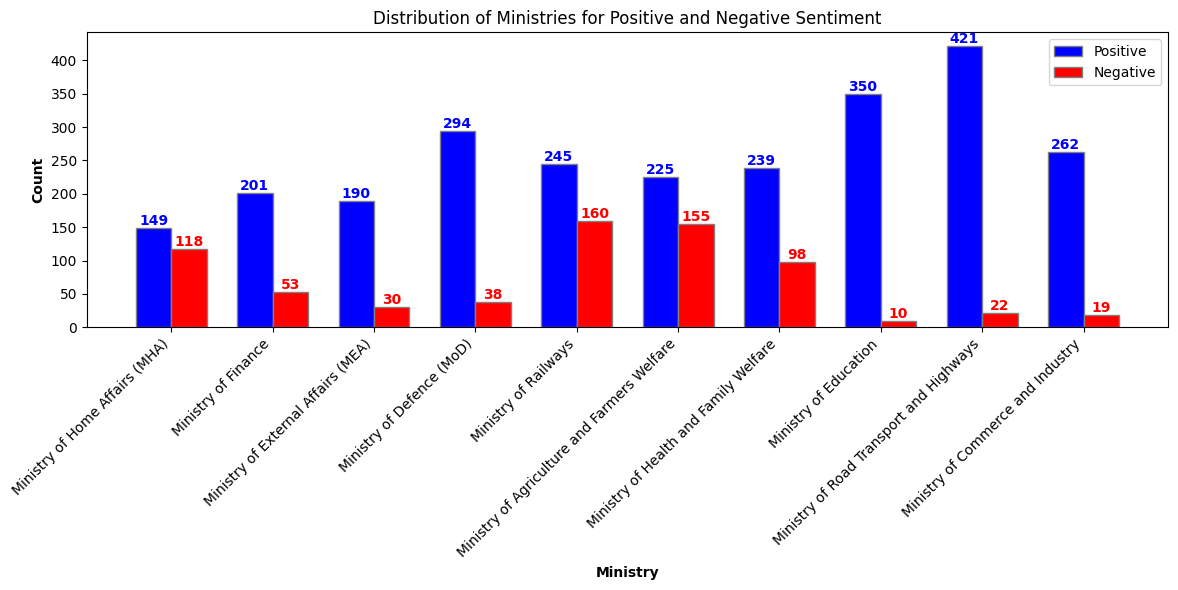

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Filter data for positive sentiment
positive_df = df_new[df_new['Sentiment'] == 'Positive']

# Filter data for negative sentiment
negative_df = df_new[df_new['Sentiment'] == 'Negative']

# Get unique ministries
ministries = df_new['Ministry'].unique()

# Count occurrences of each ministry for positive sentiment
positive_ministry_counts = positive_df['Ministry'].value_counts().reindex(ministries, fill_value=0)

# Count occurrences of each ministry for negative sentiment
negative_ministry_counts = negative_df['Ministry'].value_counts().reindex(ministries, fill_value=0)

# Plot side-by-side bar chart
plt.figure(figsize=(12, 6))

# Set width of bars
bar_width = 0.35

# Set position of bar on X axis
r1 = np.arange(len(ministries))
r2 = [x + bar_width for x in r1]

# Plot bars for positive sentiment
bars1 = plt.bar(r1, positive_ministry_counts.values, color='b', width=bar_width, edgecolor='grey', label='Positive')

# Plot bars for negative sentiment
bars2 = plt.bar(r2, negative_ministry_counts.values, color='r', width=bar_width, edgecolor='grey', label='Negative')

# Add xticks on the middle of the group bars
plt.xlabel('Ministry', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.title('Distribution of Ministries for Positive and Negative Sentiment')
plt.xticks([r + bar_width/2 for r in range(len(ministries))], ministries, rotation=45, ha='right')

# Add counts on bars
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom', fontweight='bold', color='blue')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom', fontweight='bold', color='red')

# Create legend & Show graphic
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
file = 'gres (1).csv'  # replace with the name of your uploaded file
new_data = pd.read_csv(file)

new_headlines = new_data['Headline'].astype(str).tolist()

# Handle missing values (NaN)
new_data['Headline'] = new_data['Headline'].fillna("")  # Replace NaN with empty string or other appropriate placeholder

# Tokenize the headlines
encodings = tokenizer(new_headlines, truncation=True, padding=True, max_length=128)

# Convert to torch tensors
input_ids = torch.tensor(encodings['input_ids'])
attention_masks = torch.tensor(encodings['attention_mask'])

# Create a Dataset class for the new data
class NewSentimentDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_masks):
        self.input_ids = input_ids
        self.attention_masks = attention_masks

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx]
        }

# Create the dataset
new_dataset = NewSentimentDataset(input_ids, attention_masks)

from torch.utils.data import DataLoader

# DataLoader for new data
new_dataloader = DataLoader(new_dataset, batch_size=8)

# Ensure the model is in evaluation mode
model.eval()

predictions = []

# Disable gradient calculations for inference
with torch.no_grad():
    for batch in new_dataloader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']

        # Get model predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).tolist()
        predictions.extend(preds)

# Map numeric labels back to sentiment strings
label_map = {0: 'Neutral', 1: 'Negative', 2: 'Positive'}
sentiments = [label_map[pred] for pred in predictions]

# Add predictions to the new data DataFrame
new_data['Sentiment'] = sentiments

# Save the results to a new CSV file
output_csv_file = 'predicted_data.csv'
new_data.to_csv(output_csv_file, index=False)

print(f"Predictions saved to '{output_csv_file}'")

KeyboardInterrupt: 